In [48]:
import sys
sys.path.append("..")
import Essentials
import Visualizer_pred

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from xgboost import plot_tree
import pandas as pd
pd.set_option('display.max_columns', None)  # Не ограничивать количество отображаемых столбцов
pd.set_option('display.max_rows', None)  # Не ограничивать количество отображаемых строк

In [50]:
data_archive = np.load('../Data_Average_Nikita.npz', allow_pickle=True)

In [51]:
def prepare_Y(y):
    timestamp = y[:, 1]   
    y = y[:, 0].reshape(len(y), 1)
    y = y.astype(np.float64)

    return y, timestamp

In [52]:
ALL_column_names_1 = data_archive['column_names_1'] 
all_X_1 = data_archive['all_X_1']
all_Y_1 = data_archive['all_Y_1']

ALL_column_names_2 = data_archive['column_names_2_cat'] 
all_X_2 = data_archive['all_X_2']
all_Y_2 = data_archive['all_Y_2']

ALL_column_names_3 = data_archive['column_names_3_cat']
all_X_3 = data_archive['all_X_3']
all_Y_3 = data_archive['all_Y_3']

column_names_2 = data_archive['column_names_2']
x_summer_half_2 = data_archive['x_summer_half_2']
y_summer_half_2 = data_archive['y_summer_half_2']
x_winter_half_2 = data_archive['x_winter_half_2']
y_winter_half_2 = data_archive['y_winter_half_2']

column_names_3 = data_archive['column_names_3']
x_summer_half_3 = data_archive['x_summer_half_3']
y_summer_half_3 = data_archive['y_summer_half_3']
x_winter_half_3 = data_archive['x_winter_half_3']
y_winter_half_3 = data_archive['y_winter_half_3']


In [53]:
all_X_1.shape

(107, 87)

In [54]:
ALL_column_names_1.shape

(87,)

In [55]:
x_train, x_test, y_train, y_test = train_test_split(all_X_1, all_Y_1, test_size=0.2, random_state=42)

In [56]:
x_train.shape

(85, 87)

In [57]:
y_train, timestamp_train = prepare_Y(y_train)

In [58]:
y_test, timestamp_test = prepare_Y(y_test)

In [59]:
x_train_winter, x_test_winter, y_train_winter, y_test_winter = train_test_split(x_winter_half_3, y_winter_half_3, test_size=0.2, random_state=10)

In [60]:
x_train_summer, x_test_summer, y_train_summer, y_test_summer = train_test_split(x_summer_half_3, y_summer_half_3, test_size=0.2, random_state=10)

In [61]:
y_train_summer, timestamp_train_summer = prepare_Y(y_train_summer)

In [62]:
y_train_winter, timestamp_train_winter = prepare_Y(y_train_winter)

In [63]:
y_test_summer, timestamp_test_summer = prepare_Y(y_test_summer)

In [64]:
y_test_winter, timestamp_test_winter = prepare_Y(y_test_winter)

In [65]:
class XGBoost(Essentials.SoftSensor):
    def __init__(self,name, x_train, y_train,column_names):
        super().__init__(name)
        self.column_names = column_names
        self.model = xgb.XGBRegressor()
        self.x_scaler = StandardScaler() 
        self.y_scaler = StandardScaler()
        self.fit_scaler(x_train, y_train)
        self.RandomizedSearchCV(x_train, y_train)
        self.train(x_train, y_train)
        self.set_model(self.model)

    def preprocessing(self, x):
        try:
            return self.x_scaler.transform(x)
        except:
            try:
               return self.y_scaler.transform(x)
            except BaseException as err:
                print("Ошибка скейлера")
                raise err
            
    def postprocessing(self, x):
        try:
            return self.x_scaler.inverse_transform(x)
        except:
            try:
               return self.y_scaler.inverse_transform(x)
            except BaseException as err:
                print("Ошибка скейлера")
                raise err

    def fit_scaler(self, x_train, y_train):
        self.x_scaler.fit(x_train)
        self.y_scaler.fit(y_train)

    def evaluate_model(self, x):
        predictions = self.get_model().predict(x)
        return predictions.reshape(-1,1)
    
    def RandomizedSearchCV(self,x_train,y_train):
        x_train_scaled = self.preprocessing(x_train) 
        y_train_scaled = self.preprocessing(y_train) 
        param_distributions = {
            'n_estimators': np.arange(10, 101, 10),
            'max_depth': np.arange(2, 8),
            'min_child_weight': np.arange(1, 4),
            'subsample': np.linspace(0.7, 1.0, num=4),
            'colsample_bytree': np.linspace(0.7, 1.0, num=4),
            'gamma': np.linspace(0, 0.3, num=4),
            'learning_rate': np.linspace(0.01, 0.07, num=4),
            'reg_alpha': np.linspace(0, 0.1, num=2),
            'reg_lambda': np.linspace(1, 4, num=4)
        }

        self.random_search = RandomizedSearchCV(
            estimator=self.model,
            param_distributions=param_distributions,
            n_iter=100,  # Количество итераций поиска. Увеличьте или уменьшите в зависимости от вычислительных ресурсов.
            scoring='r2',
            cv=3,  # Кросс-валидация по 3 блокам
            verbose=1,
            random_state=42,
            n_jobs=-1  # Используйте все доступные ядра
        )
        self.random_search.fit(x_train_scaled, y_train_scaled)
        self.best_params = self.random_search.best_params_
    
    def train(self, x_train, y_train):
        x_train_scaled = self.preprocessing(x_train) 
        y_train_scaled = self.preprocessing(y_train)
        self.model = xgb.XGBRegressor(**self.random_search.best_params_)
        self.model.fit(x_train_scaled,y_train_scaled)

    def treeviz(self, feature_names):
        random_tree = self.model.estimators[0]
        plt.figure(figsize=(100, 80))
        plot_tree(random_tree, feature_names=feature_names, class_names=None, filled=True)
        plt.show()
        plt.savefig('decision_tree.png')

    def __str__(self):
        # Создайте строковое представление лучших параметров с тремя знаками после запятой для чисел с плавающей точкой
        best_params_str = "\n".join(
            f"{key}: {value:.3f}" if isinstance(value, float) else f"{key}: {value}"
            for key, value in self.best_params.items()
        )
        
        # Создайте DataFrame для строкового представления важности признаков
        feature_importances = self.get_model().feature_importances_
        feature_names = self.column_names
        importances_with_names = pd.DataFrame({
            'Название признака': feature_names,
            'Важность': feature_importances
        })
        
        # Возвращение строки с информацией только о параметрах и важности признаков
        return (f"Лучшие параметры:\n{best_params_str}\n\n"
                f"Важность признаков:\n{importances_with_names.to_string(index=False)}")

In [66]:
XGBoost_test = XGBoost("XGBoost",x_train, y_train, ALL_column_names_1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [67]:
metric = Essentials.R2Metric()

In [68]:
print(XGBoost_test)

Лучшие параметры:
subsample: 1.000
reg_lambda: 1.000
reg_alpha: 0.100
n_estimators: 100
min_child_weight: 2
max_depth: 2
learning_rate: 0.030
gamma: 0.200
colsample_bytree: 1.000

Важность признаков:
                         Название признака  Важность
           Расход бензина ККР на установку  0.000000
             Расход нафты ККР на установку  0.000000
  Расход бензина на рециркуляцию от Е-1205  0.000000
      Температура бензина ККР на установку  0.020620
                 Расход сырья после Р-1101  0.000000
 Показатель соотношения водород к углероду  0.000000
  Расход водорода на смешение перед Е-1101  0.000000
            Температура сырья перед Е-1101  0.019679
               Давление сырья перед Е-1101  0.000000
            Температура сырья перед Е-1102  0.000000
            Температура сырья перед Е-1103  0.000000
               Давление сырья перед Е-1103  0.027820
            Температура сырья после Е-1103  0.000000
               Температура ТБ перед Е-1101  0.000000
     

<Axes: >

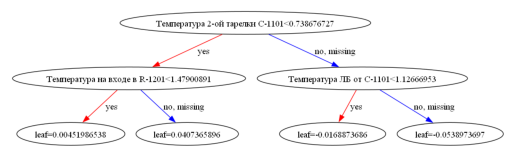

In [69]:
XGBoost_test.model.get_booster().feature_names = list(ALL_column_names_1)
xgb.plot_tree(XGBoost_test.model, num_trees=0)

In [70]:
test_visual=Visualizer_pred.Visualizer(x_test, y_test, timestamp_test, [metric], 'Linear with PCA SoftSensor R2 and MSE metric on Test')

+---------+--------------------------------+---------+
|         |   Coefficient of determination |     MSE |
+=========+================================+=========+
| XGBoost |                       0.706521 | 3.25401 |
+---------+--------------------------------+---------+


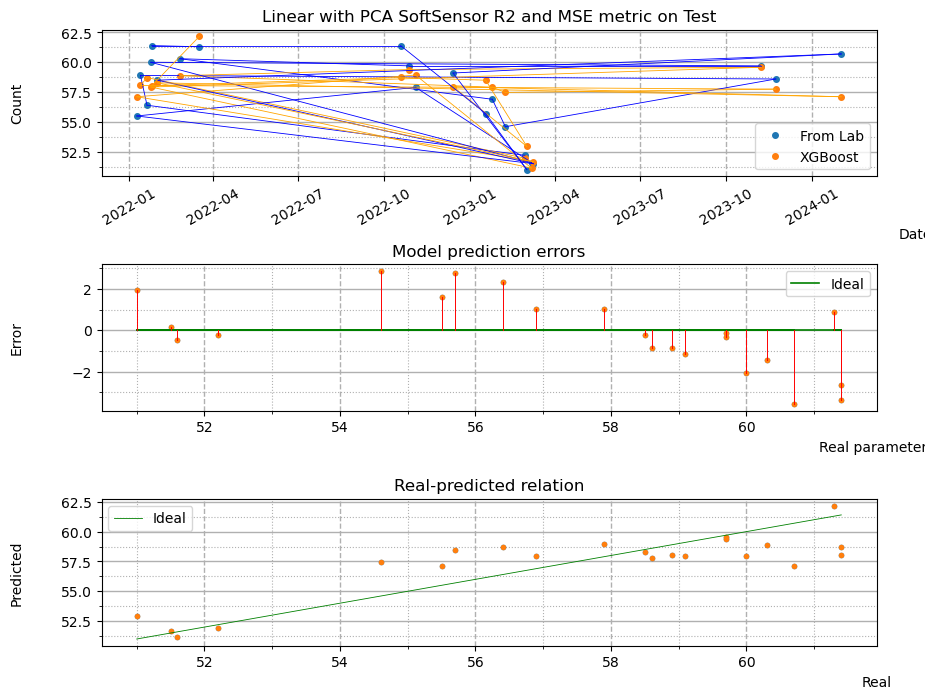

In [71]:
test_visual.visualize([XGBoost_test], lines=True, lines_vertical=True)